<a href="https://colab.research.google.com/github/wristi/Capstone/blob/main/classification_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.applications import ResNet101V2
from keras import models, layers, optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.utils import to_categorical


import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import numpy as np

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Keras Image Data Loading
ref: https://keras.io/api/data_loading/image/

In [5]:

def create_dataset(data_dir, shuffle=True):
    # Use ImageDataGenerator for normalization
    datagen = ImageDataGenerator(rescale=1./255)

    # Create a TensorFlow dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        image_size=(224, 224),
        shuffle=shuffle,
        seed=42,
        validation_split=0.2,
        subset="training",
        interpolation="bilinear",
        crop_to_aspect_ratio=True
    )

    val_dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        image_size=(224, 224),
        shuffle=shuffle,
        seed=42,
        validation_split=0.2,
        subset="validation",
        interpolation="bilinear",
        crop_to_aspect_ratio=True
    )

    # Determine batch size dynamically
    #batch_size = tf.data.experimental.cardinality(train_dataset).numpy()
    #print(f"Using batch size: {batch_size}")
    return train_dataset, val_dataset


In [8]:
# Example usage:

data_directory = 'drive/MyDrive/Pollen_RawData/'

train_dataset,val_dataset = create_dataset(data_directory, shuffle=True)


Found 1034 files belonging to 5 classes.
Using 828 files for training.
Found 1034 files belonging to 5 classes.
Using 206 files for validation.


In [9]:
class_names = train_dataset.class_names
print(class_names)

['Eringonum rosense', 'Eriogonum umbellatum', 'Erysimum capitatum', 'Penstemon eatonii', 'Purshia tridentata']


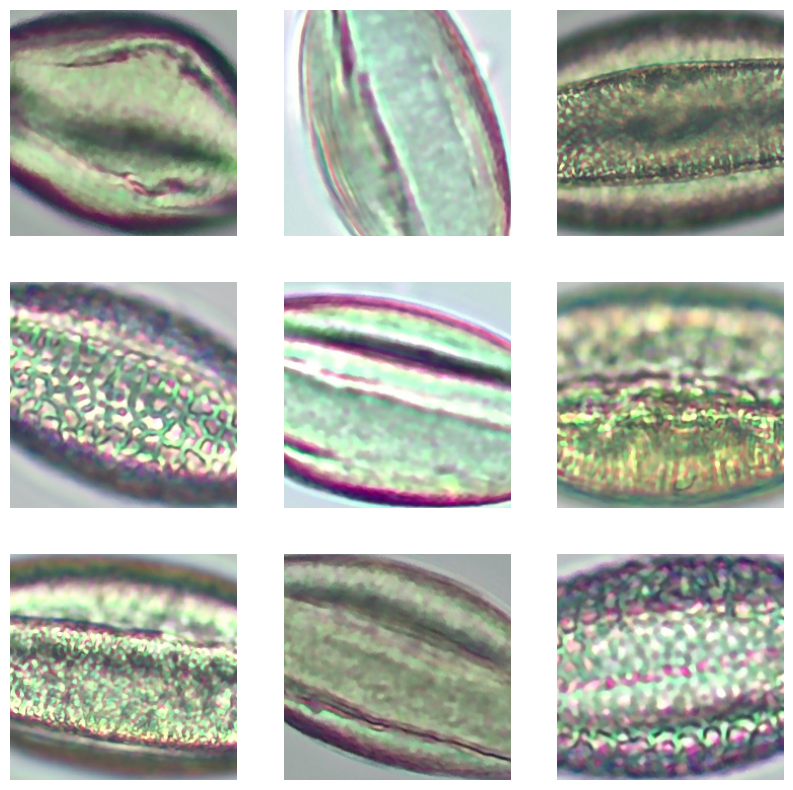

In [10]:

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

# Resnet Classification Training
ref: https://keras.io/guides/transfer_learning/#build-a-model

In [11]:


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [13]:

def train_model(train_dataset, val_dataset, num_classes, epochs=10, batch_size=32):


    # Load the pre-trained ResNet50 model
    base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model for transfer learning
    model = models.Sequential()

    # Add the pre-trained ResNet50 model
    model.add(base_model)

    # Flatten the xoutput of the ResNet50 model
    model.add(layers.Flatten())

    # Add your own fully connected layers for classification
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Categorical classification

    # Compile the model with Adam optimizer & slow learning rate
    optimizer = optimizers.Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

    # Create a TensorBoard callback
    tensorboard_callback = TensorBoard(
    log_dir='/logs/train',  # Directory where to write the logs
    histogram_freq=1,   # Frequency (in epochs) at which to compute activation and weight histograms for the layers of the model
    write_images=True   # Whether to visualize the model's graph as an image in TensorBoard
)

    # Callback to adjust learning rate during training
    def lr_schedule(epoch):
        initial_lr = 1e-4
        decay_factor = 0.9
        lr = initial_lr * (decay_factor ** epoch)
        return lr

    lr_scheduler = LearningRateScheduler(lr_schedule)


    model.summary()
    # Train the model
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[lr_scheduler, tensorboard_callback])


    return model, history


In [1]:
# Assuming you have already created train_dataset and val_dataset using create_dataset

#5 Output Neurons
trained_model, training_history = train_model(train_dataset, val_dataset, epochs=10,num_classes=5)


NameError: name 'train_model' is not defined

In [2]:


# Assuming you've trained your model using model.fit(...) and stored the result in 'history'


# Plot training history
plt.plot(training_history.history['loss'], label='Training Loss')

plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
# Make Predictions
predictions = trained_model.predict(train_dataset)

# Convert Predictions to Class Labels
predicted_labels = np.argmax(predictions, axis=1)

true_label = np.argmax(true_labels)
predicted_label = np.argmax(predicted_labels)

# Convert Predictions to Class Labels
# Compute Confusion Matrix
conf_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

####CONFUSIONMATRIX STILL DOESN'T WORK, COULDNT DEBUG


26/26 [==============================] - 42s 2s/step


InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [32,5] != values[1].shape = [828] [Op:Pack] name: stack

In [3]:

def train_model_augmentation(train_dataset, val_dataset, num_classes, epochs=10, batch_size=32):


    # Load the pre-trained ResNet50 model
    base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Define data augmentation layers directly within the model
    data_augmentation = models.Sequential([
        layers.experimental.preprocessing.RandomFlip('horizontal'),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.RandomHeight(0.2),
        layers.experimental.preprocessing.RandomContrast(0.2)
    ], name='data_augmentation')

    # Create a new model for transfer learning
    model = models.Sequential([
        data_augmentation,
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Add the pre-trained ResNet50 model
    model.add(base_model)

    # Flatten the xoutput of the ResNet50 model
    model.add(layers.Flatten())

    # Add your own fully connected layers for classification
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Categorical classification

    # Compile the model with Adam optimizer & slow learning rate
    optimizer = optimizers.Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_m])

    # Callback to adjust learning rate during training
    def lr_schedule(epoch):
        initial_lr = 1e-4
        decay_factor = 0.9
        lr = initial_lr * (decay_factor ** epoch)
        return lr

    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Callback to log data for TensorBoard
    tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_images=True)


    model.summary()
    # Train the model
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[lr_scheduler, tensorboard_callback])


    return model, history



In [4]:
# Assuming you have already created train_dataset and val_dataset using create_dataset

#5 Output Neurons
augmented_trained_model, augmented_training_history = train_model_augmentation(train_dataset, val_dataset, epochs=10,num_classes=5)



NameError: name 'train_dataset' is not defined

In [ ]:
# finished with 23% Accuracy
# 1.57 Loss

Running Classification on Lice Dataset

In [ ]:
# Example usage:
data_directory = 'Lice_dataset/'

lice_train,lice_val = create_dataset(data_directory, shuffle=True)



Found 1239 files belonging to 5 classes.
Using 992 files for training.
Found 1239 files belonging to 5 classes.
Using 247 files for validation.


In [ ]:
# Assuming you have already created train_dataset and val_dataset using create_dataset

#5 Output Neurons
trained_model, training_history = train_model(lice_train, lice_val, epochs=10,num_classes=5)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten_8 (Flatten)         (None, 100352)            0         
                                                                 
 dense_16 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 5)                

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-02-15 12:35:51.694406: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [992]
	 [[{{node Placeholder/_0}}]]
2024-02-15 12:35:51.694866: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [992]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - ETA: 0s - loss: 645.2692 - accuracy: 0.2127 - recall_m: 0.2127 - precision_m: 0.2127 - f1_m: 0.2127

2024-02-15 12:37:08.194588: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [247]
	 [[{{node Placeholder/_4}}]]
2024-02-15 12:37:08.194841: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [247]
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 121s 4s/step - loss: 645.2692 - accuracy: 0.2127 - recall_m: 0.2127 - precision_m: 0.2127 - f1_m: 0.2127 - val_loss: 94.7939 - val_accuracy: 0.3441 - val_recall_m: 0.3427 - val_precision_m: 0.3427 - val_f1_m: 0.3427 - lr: 1.0000e-04
Epoch 2/10
31/31 [==============================] - 120s 4s/step - loss: 105.4668 - accuracy: 0.3034 - recall_m: 0.3014 - precision_m: 0.3032 - f1_m: 0.3022 - val_loss: 2.8230 - val_accuracy: 0.2632 - val_recall_m: 0.1873 - val_precision_m: 0.3349 - val_f1_m: 0.2393 - lr: 9.0000e-05
Epoch 3/10
31/31 [==============================] - 111s 4s/step - loss: 2.2561 - accuracy: 0.3085 - recall_m: 0.0353 - precision_m: 0.1328 - f1_m: 0.0467 - val_loss: 1.6081 - val_accuracy: 0.3117 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00 - lr: 8.1000e-05
Epoch 4/10
31/31 [==============================] - 109s 4s/step - loss: 1.6290 - accuracy: 0.3226 - recall_m: 0.0060 - precision_m: 0.1290 - f1_m: 

32% Accuracy